# OpenStreetMap Data Wrangling with MongoDB

## Project Overview
Choose any area of the world in https://www.openstreetmap.org and use data munging techniques, such as assessing the quality of the data for validity, accuracy, completeness, consistency and uniformity, to clean the OpenStreetMap data for a part of the world that you care about. Choose to learn SQL or MongoDB and apply your chosen schema to the project.

### OSM Dataset
The dataset selected for this project is of the region covering Kansas city, Lawrence and Topeka.

Data was pulled from mapzen
- https://mapzen.com/data/metro-extracts/metro/kansas-city-lawrence-topeka_kansas/

I am using Robomongo as a interface tool for quering

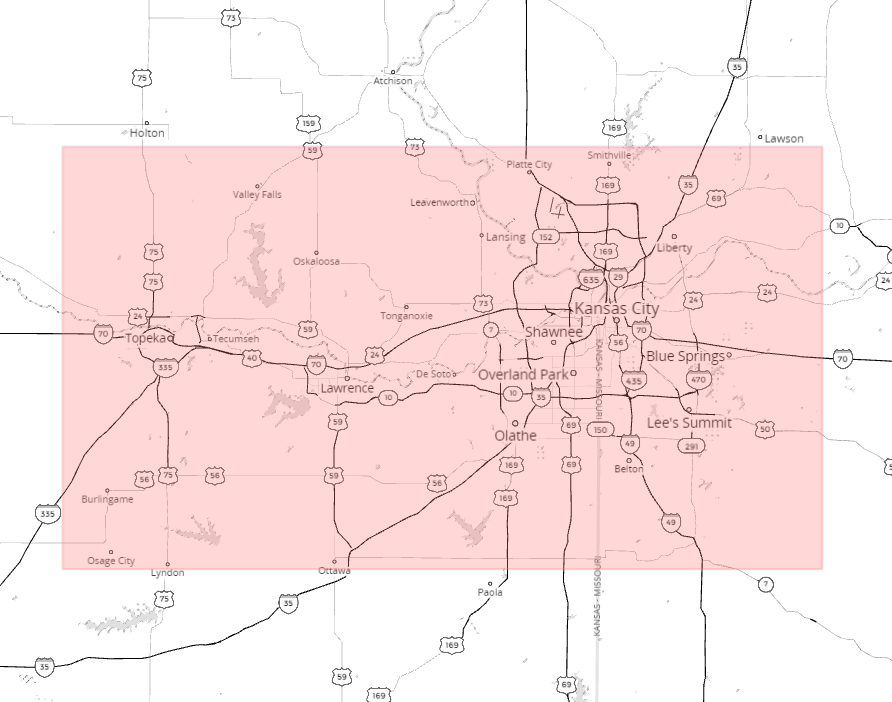

In [8]:
from IPython.display import Image
Image("kansas.png", width ="1200")

## Problems Encountered in the Map

### Issues
I noticed some problems with the data.  Each of them will be highlighted below.

- Abbreviated street names (St. for Street, Rd. for Road)
- Some street names are not standarized (9th street instead of 9th Street)
- Multiple abbreviations in values (St. Pkwy of Queen Street Parkway)
- Incorrect and inconsistent postal codes (format)

**Street Names**
The followings are all the inconsistent street name, I found in the dataset:

- E Valley View Pkwy ===> E Valley View Parkway
- S Noland Rd ===> S Noland Road
- W. 80 St. ===> W. 80 Street
- 3345 SW Fairlawn Rd ===> 3345 SW Fairlawn Road
- Northwest 900th Rd ===> Northwest 900th Road
- East 23rd St. ===> East 23rd Street
- Armour Rd ===> Armour Road
- Stillwell Rd ===> Stillwell Road
- Lackman Rd ===> Lackman Road
- W 87th St. ===> W 87th Street
- 8941 James A. Reed Rd ===> 8941 James A. Reed Road
- S Blackbob Rd ===> S Blackbob Road
- Truman Rd ===> Truman Road
- W 80th St. ===> W 80th Street
- Woodswether Rd ===> Woodswether Road
- Shawnee Mission Pkwy ===> Shawnee Mission Parkway
- Centennial St. ===> Centennial Street
- West 119th St. ===> West 119th Street
- SW Harper St. ===> SW Harper Street
- Southeast Croco Rd ===> Southeast Croco Road
- Pride Pkwy ===> Pride Parkway
- Cantrell Rd ===> Cantrell Road
- Rockhill Rd. ===> Rockhill Road
- W. Mechanic St. ===> W. Mechanic Street
- State Line Rd ===> State Line Road
- Northwest Chipman Rd ===> Northwest Chipman Road
- 13770 S Black Bob Rd ===> 13770 S Black Bob Road
- Folks Rd. ===> Folks Road
- Lydia St. ===> Lydia Street
- W 87th St. Pkwy ===> W 87th St. Parkway
- Maurer Rd ===> Maurer Road
- 3907 SW Burlingame Rd ===> 3907 SW Burlingame Road
- Barry Rd ===> Barry Road
- E. 9th St. ===> E. 9th Street
- Winner Rd ===> Winner Road
- 6434 NW Crooked Rd ===> 6434 NW Crooked Road
- North Antioch Rd ===> North Antioch Road



**Postal Codes**
US postal code or zipcode has two formats: the basic 5-digit format and the extended 9 digits after a dash to form a ZIP+4 code. So we need a regex which can satisfy all condtions for zip-code. Therefore, the full RegEx is below:
> \d{5}(?:[-\s]\d{4})?$

Postal Codes: **KS, 4081, MO, W Pershing** were found and are incorrectly formatted 

## Analysis

### Data Overview
Basic statistics and the queries used to collect them

**General information**
- kansas-city-lawrence-topeka_kansas.osm: 474MB
- kansas-city-lawrence-topeka_kansas.osm.json: 531MB

> db.stats()
-    "db" : "kansas",
-    "collections" : 1,
-    "views" : 0,
-    "objects" : 2284007,
-    "avgObjSize" : 253.999866024929,
-    "dataSize" : 580137472.0,
-    "storageSize" : 178864128.0,
-    "numExtents" : 0,
-    "indexes" : 1,
-   "indexSize" : 20602880.0,
-    "ok" : 1.0


**Number of documents: 2284007 **
                                                
> db.getCollection('kansas_map').find().count()
                                                
**Number of nodes: 2026659**
                                                
> db.getCollection('kansas_map').find({"type":"node"}).count()
                                                
**Number of ways: 257112**
                                                
> db.getCollection('kansas_map').find({"type":"way"}).count()
                                                
**Number of unique users: 1119**
                                                
> db.getCollection('kansas_map').distinct("created.user").length
                                       
**Top 3 contributors:**
>db.getCollection('kansas_map').aggregate([

>     {$match: {'created.user': {$exists: 1} }},
     {$group: {_id: '$created.user','count':{$sum: 1}}},
     {$sort: {'count': -1}},
     {$limit: 3}
> ])

> - { "_id" : "woodpeck_fixbot", "count" : 485270 }
> - { "_id" : "James Michael DuPont", "count" : 287876 }
> - { "_id" : "DeVietor", "count" : 203726 }

**Number of amenity with addresses**

> db.getCollection('kansas_map').aggregate([

>     {$match:{'amenity':{'$exists':1},'address':{'$exists':1}}},
>     {\$group: {
>          _id: null,
>          count: { \$sum: 1 }
>     }
>  }
> ])

{
    "_id" : null,
    "count" : 2638.0
}

**Number of amenity with NO addresses**

> db.getCollection('kansas_map').aggregate([

>     {$match:{'amenity':{'$exists':1},'address':{'$exists':0}}},
>     {\$group: {
>          _id: null,
>          count: { \$sum: 1 }
>     }
>  }
> ])


{
    "_id" : null,
    "count" : 11954.0
}


There are about 82% of amenity without addresses

### Code details

Some most importan parts in the code.

** Validating data tag 'k' attribute **

In [ ]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    """
        search returns matchObject which is always true or None when 'false'
    """
    if element.tag == "tag":
        if lower.search(element.attrib['k']):
            keys["lower"] += 1
        elif lower_colon.search(element.attrib['k']):
            keys["lower_colon"] += 1
        elif problemchars.search(element.attrib['k']):
            keys["problemchars"] += 1
        else:
            keys["other"] += 1
        
    return keys



def process_map(filename):
    """Count occurents for keys"""
    
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys



def test():
    # You can use another testfile 'map.osm' to look at your solution
    # Note that the assertion below will be incorrect then.
    # Note as well that the test function here is only used in the Test Run;
    # when you submit, your code will be checked against a different dataset.
    keys = process_map('example.osm')
    pprint.pprint(keys)
    assert keys == {'lower': 5, 'lower_colon': 0, 'other': 1, 'problemchars': 1}

**Postal code validation**

In [ ]:
postal_codes = re.compile(r'\d{5}(?:[-\s]\d{4})?$')

def audit_postal_code(postal_code):
    """
        Return matched postal code and add bad ones to list.
        args:
            postal_code(string)
        returns:
            matched_postal_code(string)
    """
    l = postal_codes.findall(postal_code)
    if len(l)>0:
        return l[0]

    # Rather None/null or a bad postal code
    bad_postal_codes.append(postal_code)
    return postal_code


def is_postal_code(address_key):
    return address_key == 'addr:postcode'

**Street name validation**

In [1]:
def standarize_name(street_name):
    """
        Standarzie street name ("south Providence road --> South Providence Road")
        Args:
            street_name(string)
        returns:
        Standarized string (string)

    """
    words = street_name.split()
    res=[]
    for word in words:
        lower = word.lower()
        l = list(lower)
        l[0] = l[0].upper()
        res = res + l +[' ']

    return str(res[0:-1])

def audit_street_type(street_name):
    """Return the fixed street name or return untouched street name if expected."""

    m = street_types.search(street_name)
    if m:
        street_type = standarize_name(m.group())
        if street_type not in expected:
            return update_street_name(street_name, street_mapping)

    return street_name


def update_street_name(name, mapping):
     """
         Update street name using mapping table
         args:
             street name(string)
             mapping(dictionary)
         returns:
             updated name (string)
     """
    m = street_types.search(name)
    street_type = m.group()
    try:
        fixed_name = name.replace(street_type, mapping[street_type])
        fixed_street_names[name] = fixed_name
    except KeyError:
        pass
    return name


def is_street_name(address_key):
    return address_key == 'addr:street'

IndentationError: unindent does not match any outer indentation level (<ipython-input-1-3dbd5ef23525>, line 18)

**MongoDB export and import of data**

JSON import code/commands
> mongoimport --db kansas --collection kansas_map --drop --file kansas-city-lawrence-topeka_kansas.osm.json

## Additional analysis and ideas

It is very common that many visitors care about interesting places when they come to a city such as: parks, museums, and even restaurants. After investigating the dataset, I can not find any information related to parks and musems but I can find trailer parks and restaurants.

** Display all the trailer parks **

> db.getCollection('kansas_map').aggregate([

>     {$match:{'amenity': /trailer_Park\$/i}},
>     {$project:{'city':'$address.city','street':'$address.street', 'No': '$address.housenumber'}},
>     {$project:{'_id':0,'Address': {$concat:['$No','-','$street',',', '$city']}}}
> ])


- {
    "Address" : "1441-Northwest Western Avenue,Topeka"
}

- {
    "Address" : "4725-Southwest Topeka Boulevard,Topeka"
}

- {
    "Address" : "4842-Southwest Topeka Boulevard,Topeka"
}

- {
    "Address" : "5720-Northwest Topeka Boulevard,Topeka"
}

- {
    "Address" : "5932-Southwest Topeka Boulevard,Topeka"
}

- {
    "Address" : "8440-Southwest Topeka Boulevard,Wakarusa"
}

- {
    "Address" : "5932-Southwest Topeka Boulevard,Topeka"
}

- {
    "Address" : "5331-Southwest Topeka Boulevard,Topeka"
}


** Which street has the most restaurants?. **

> db.getCollection('kansas_map').aggregate([

>     {$match:{'amenity':{'$exists':1}, 'amenity':/restaurant/i,'address':{'$exists':1}, 'address.street':{'$exists':1},  'address.postcode':{'\$exists':1} } },

>     {$group:{'_id':{'street':'$address.street', 'postcode': '$address.postcode' }, 'count':{'$sum':1}}},

>     {$sort:{'count':-1}},
>     {$limit:5}
> ])

- {
    "_id" : {
        "street" : "Southwest Wanamaker Road",
        "postcode" : "66604"
    },
    "count" : 15.0
}

- {
    "_id" : {
        "street" : "North Oak Trafficway",
        "postcode" : "64118"
    },
    "count" : 15.0
}

- {
    "_id" : {
        "street" : "Southwest Topeka Boulevard",
        "postcode" : "66611"
    },
    "count" : 12.0
}

- {
    "_id" : {
        "street" : "Southwest 29th Street",
        "postcode" : "66614"
    },
    "count" : 10.0
}

- {
    "_id" : {
        "street" : "North Village West Parkway",
        "postcode" : "66111"
    },
    "count" : 8.0
}

### Final thoughts
After review and investigation, it’s obvious that the region of Kansas city, Lawrence and Topeka is incomplete. There are a lot of amenities without addresses although I have to say I am so impressed with the completeness of the zipcode and street name data. It does not provide any information related to interesting places such as parks, museums, and cinemas, ..etc.
To make the OpenStreetMap more completed, we can not only count on only human efforts. I think social networks are good mediums to improve the dataset. There are so many social networks out there and most of people, no matter where they are, have at least a socical account such as: Facebook, Twitter, etc. I usually myself see some posts from my friends saying they are checking an interesting place. If we can develop a robus method to combine those infomation with cellphones's GPS, we can efficiently update the dataset. Beside social networks, we can think about of virtual reality games. Pokemon Go is an excelent example. In Pokemon Go, there are pokestop refering to interesting places that can also be used for the improvement. It is ovbvious that implementing the improvement is not a trivial task since we have to deal with some isues such as fake information, privacies and big data handling but I strongly believe that it would be possible to input a great amount of cleaned data in the dataset 



## References
- http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree
- https://docs.python.org/2/library/re.html
- http://wiki.openstreetmap.org/wiki/OSM_XML
- https://www.openstreetmap.org/relation/2989349#map=12/43.6789/-79.3851
- https://docs.mongodb.org/manual
- https://robomongo.org/